In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [3]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from tensorflow.keras.regularizers import l2
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, BatchNormalization,Dense,Conv2D,Input,MaxPooling2D,Dropout,Flatten
from tensorflow.keras.optimizers import Adam

In [4]:
gpu_device = tf.config.experimental.list_physical_devices('GPU')[0]
tf.config.experimental.set_virtual_device_configuration(gpu_device, [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=6144)])
tf.config.experimental.set_visible_devices(gpu_device, 'GPU')

2023-01-09 02:39:17.199949: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-09 02:39:17.200906: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-09 02:39:17.420022: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-09 02:39:17.420897: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-09 02:39:17.421679: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

In [5]:
train = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')
test = pd.read_csv('/kaggle/input/digit-recognizer/test.csv')

In [6]:
train_images = train.iloc[:,1:].values.reshape(-1,28,28,1)

In [7]:
def randomDigits():
    fig, ax = plt.subplots(5, 5, figsize=(10, 10))
    for i, axi in enumerate(ax.flat):
        index = np.random.randint(0, train_images.shape[0])
        axi.imshow(train_images[index].reshape(28, 28), cmap='gray', interpolation='nearest')
        axi.set(xticks=[], yticks=[],
                xlabel=str(train.iloc[index, 0]))

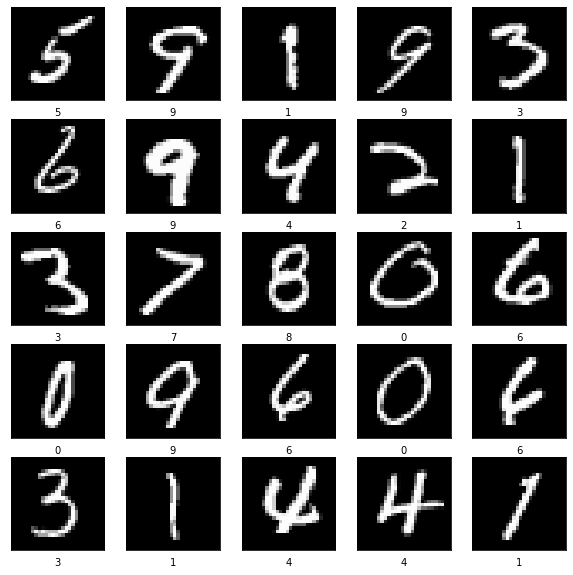

In [8]:
# Show random samnple of digits image in the dataset
randomDigits()

In [9]:
X_train, X_val, y_train, y_val = train_test_split(train_images, train['label'], test_size=0.2, random_state=0)

In [10]:
print("X_train shape: ", X_train.shape)
print("X_val shape: ", X_val.shape)
print("y_train shape: ", y_train.shape)
print("y_val shape: ", y_val.shape)

X_train shape:  (33600, 28, 28, 1)
X_val shape:  (8400, 28, 28, 1)
y_train shape:  (33600,)
y_val shape:  (8400,)


In [12]:
def plotDistribution(data, title, labels):
  plt.figure(figsize=(10, 5))
  plt.bar(np.arange(10), data, color=plt.cm.tab20(np.arange(10)))
  plt.xlabel('Digits')
  plt.ylabel('Count')
  plt.xticks(np.arange(10), labels)
  plt.title(title)
  plt.show()

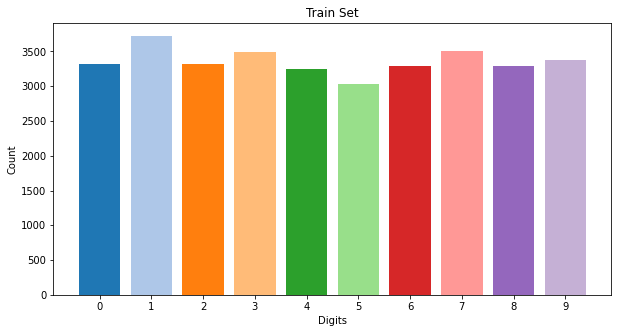

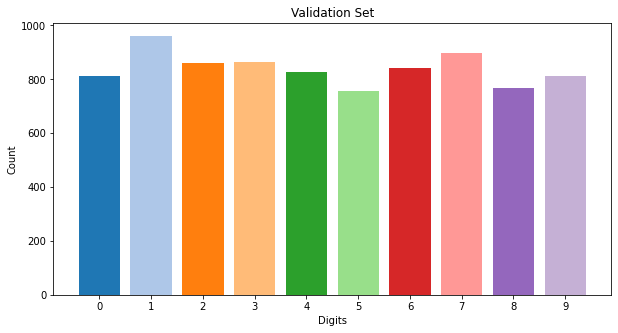

In [13]:
plotDistribution(y_train.value_counts().sort_index(), 'Train Set', y_train.value_counts().sort_index().index)
plotDistribution(y_val.value_counts().sort_index(), 'Validation Set', y_val.value_counts().sort_index().index)

In [14]:
y_train.value_counts().sort_index()

0    3319
1    3723
2    3317
3    3488
4    3245
5    3039
6    3296
7    3502
8    3295
9    3376
Name: label, dtype: int64

In [15]:
y_val.value_counts().sort_index()

0    813
1    961
2    860
3    863
4    827
5    756
6    841
7    899
8    768
9    812
Name: label, dtype: int64

In [16]:
with tf.device('/GPU:0'):
  model = tf.keras.models.Sequential([
      Input(shape=(28, 28, 1)),

      Conv2D(filters = 32, kernel_size = 5, strides = 1, activation = 'relu', kernel_regularizer=l2(0.0005)),
      Conv2D(filters = 32, kernel_size = 5, strides = 1, activation = 'relu', use_bias=False),
      BatchNormalization(),
      MaxPooling2D(strides = 2),
      Dropout(0.3),

      Conv2D(filters = 64, kernel_size = 3, strides = 1, activation = 'relu', kernel_regularizer=l2(0.0005)),
      Conv2D(filters = 64, kernel_size = 3, strides = 1, activation = 'relu', use_bias=False),
      BatchNormalization(),
      MaxPooling2D(strides = 2),
      Dropout(0.3),

      Flatten(),
      Dense(units  = 256, activation = 'relu', use_bias=False),
      BatchNormalization(),

      Dense(units = 128, use_bias=False, activation = 'relu', kernel_regularizer=l2(0.0005)),

      Dense(units = 84, use_bias=False, activation = 'relu', kernel_regularizer=l2(0.0005)),
      BatchNormalization(),
      Dropout(0.3),

      Dense(units = 10, activation = 'softmax')
  ])

2023-01-09 02:48:05.584401: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-09 02:48:05.585011: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-09 02:48:05.586078: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-09 02:48:05.586945: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 24, 24, 32)        832       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 20, 20, 32)        25600     
_________________________________________________________________
batch_normalization (BatchNo (None, 20, 20, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 10, 10, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 10, 10, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 64)          18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 6, 6, 64)          3

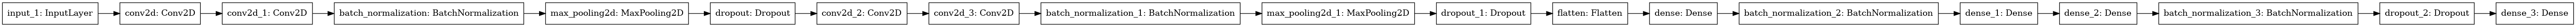

In [18]:
from keras.utils.vis_utils import plot_model
plot_model(model, rankdir='LR')

In [23]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [24]:
with tf.device ('/device:GPU:0'):
  history = model.fit(X_train, tf.keras.utils.to_categorical(y_train), epochs=100, batch_size=16, validation_data=(X_val, tf.keras.utils.to_categorical(y_val)), callbacks=[
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=5, min_delta=0.005, verbose=1, learning_rate=0.01),
    tf.keras.callbacks.TensorBoard(log_dir='/kaggle/working/TensorLogs/CNNTest5.0', histogram_freq=1, write_graph=True, write_images=True, update_freq='epoch', profile_batch=2, embeddings_freq=1, embeddings_metadata=None),
  ], shuffle=True)

2023-01-09 03:01:48.258308: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2023-01-09 03:01:48.258352: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2023-01-09 03:01:48.268056: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1614] Profiler found 2 GPUs
2023-01-09 03:01:48.576283: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2023-01-09 03:01:48.576500: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2023-01-09 03:01:49.318230: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


2023-01-09 03:01:52.409225: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


   1/2100 [..............................] - ETA: 7:48:06 - loss: 3.6525 - accuracy: 0.0625

2023-01-09 03:02:02.848494: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2023-01-09 03:02:02.848538: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


   2/2100 [..............................] - ETA: 22:30 - loss: 3.7463 - accuracy: 0.0625  

2023-01-09 03:02:03.464653: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2023-01-09 03:02:03.465432: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2023-01-09 03:02:03.602545: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 275 callback api events and 272 activity events. 
2023-01-09 03:02:03.616086: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2023-01-09 03:02:03.642537: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: /kaggle/working/TensorLogs/CNNTest5.0/train/plugins/profile/2023_01_09_03_02_03

2023-01-09 03:02:03.649934: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to /kaggle/working/TensorLogs/CNNTest5.0/train/plugins/profile/2023_01_09_03_02_03/9761045ac7e5.trace.json.gz


  33/2100 [..............................] - ETA: 1:06 - loss: 2.5381 - accuracy: 0.2557

2023-01-09 03:02:03.689581: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: /kaggle/working/TensorLogs/CNNTest5.0/train/plugins/profile/2023_01_09_03_02_03

2023-01-09 03:02:03.692431: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to /kaggle/working/TensorLogs/CNNTest5.0/train/plugins/profile/2023_01_09_03_02_03/9761045ac7e5.memory_profile.json.gz
2023-01-09 03:02:03.693330: I tensorflow/core/profiler/rpc/client/capture_profile.cc:251] Creating directory: /kaggle/working/TensorLogs/CNNTest5.0/train/plugins/profile/2023_01_09_03_02_03
Dumped tool data for xplane.pb to /kaggle/working/TensorLogs/CNNTest5.0/train/plugins/profile/2023_01_09_03_02_03/9761045ac7e5.xplane.pb
Dumped tool data for overview_page.pb to /kaggle/working/TensorLogs/CNNTest5.0/train/plugins/profile/2023_01_09_03_02_03/9761045ac7e5.overview_page.pb
Dumped tool data for input_pipeline.pb to /kaggle/working/TensorLogs/CNNTest

2100/2100 [==============================] - 27s 6ms/step - loss: 0.4873 - accuracy: 0.8954 - val_loss: 0.2205 - val_accuracy: 0.9742
Epoch 2/100
2100/2100 [==============================] - 12s 6ms/step - loss: 0.2489 - accuracy: 0.9600 - val_loss: 0.1862 - val_accuracy: 0.9719
Epoch 3/100
2100/2100 [==============================] - 12s 6ms/step - loss: 0.1939 - accuracy: 0.9679 - val_loss: 0.1229 - val_accuracy: 0.9843
Epoch 4/100
2100/2100 [==============================] - 12s 6ms/step - loss: 0.1571 - accuracy: 0.9734 - val_loss: 0.1062 - val_accuracy: 0.9868
Epoch 5/100
2100/2100 [==============================] - 12s 6ms/step - loss: 0.1426 - accuracy: 0.9763 - val_loss: 0.0975 - val_accuracy: 0.9886
Epoch 6/100
2100/2100 [==============================] - 13s 6ms/step - loss: 0.1241 - accuracy: 0.9799 - val_loss: 0.0847 - val_accuracy: 0.9905
Epoch 7/100
2100/2100 [==============================] - 12s 6ms/step - loss: 0.1189 - accuracy: 0.9801 - val_loss: 0.0866 - val_accurac

In [25]:
def plotLossAndAccuracy(history):
  fig, ax = plt.subplots(1, 2, figsize=(15, 5))
  ax[0].plot(history.history['loss'], label='Train Loss', color='green')
  ax[0].plot(history.history['val_loss'], label='Validation Loss', color='purple')
  ax[0].set_facecolor('black')
  ax[0].grid(color='white', linestyle='-', linewidth=0.5)
  ax[0].legend()
  ax[0].set_title('Loss')
  ax[0].set_xlabel('Epochs')
  ax[0].set_ylabel('Loss')
  ax[1].plot(history.history['accuracy'], label='Train Accuracy', color='green')
  ax[1].plot(history.history['val_accuracy'], label='Validation Accuracy', color='purple')
  ax[1].set_facecolor('black')
  ax[1].grid(color='white', linestyle='-', linewidth=0.5)
  ax[1].legend()
  ax[1].set_title('Accuracy')
  ax[1].set_xlabel('Epochs')
  ax[1].set_ylabel('Accuracy')
  plt.show()

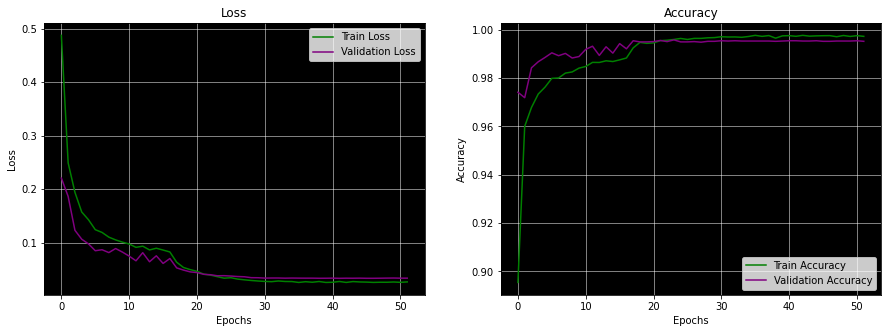

In [26]:
plotLossAndAccuracy(history)

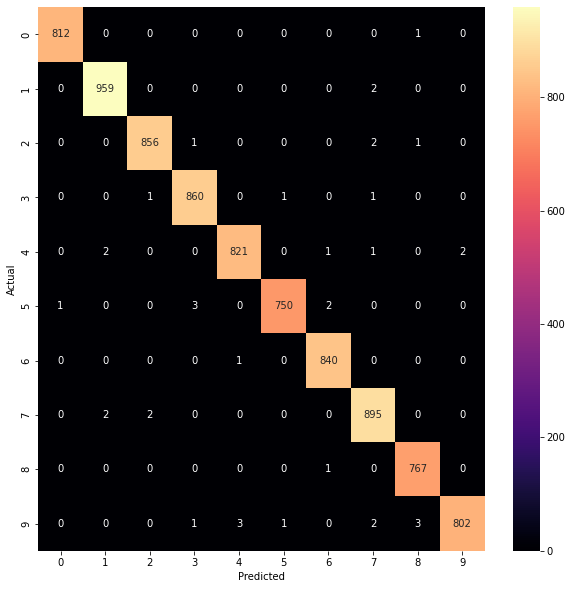

In [27]:
cm = tf.math.confusion_matrix(y_val, np.argmax(model.predict(X_val), axis=1))
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='magma')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [28]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print('Accuracy: ', accuracy_score(y_val, np.argmax(model.predict(X_val), axis=1)))
print('Precision: ', precision_score(y_val, np.argmax(model.predict(X_val), axis=1), average='macro'))
print('Recall: ', recall_score(y_val, np.argmax(model.predict(X_val), axis=1), average='macro'))
print('F1 Score: ', f1_score(y_val, np.argmax(model.predict(X_val), axis=1), average='macro'))

Accuracy:  0.9954761904761905
Precision:  0.9955272521787786
Recall:  0.9954113963687984
F1 Score:  0.9954642938435242


In [30]:
test_images = test.values.reshape(-1, 28, 28, 1)

In [31]:
predictions = np.argmax(model.predict(test_images), axis=1)

In [33]:
def randomDigitsTest():
  import random

  random_indices = random.sample(range(len(test_images)), 25)

  fig, ax = plt.subplots(5, 5, figsize=(25, 25))
  for index, axi in enumerate(ax.flat):

    image = test_images[random_indices[index]].reshape(28, 28)
    prediction = predictions[random_indices[index]]

    axi.imshow(image, cmap='gray', interpolation='nearest', aspect='auto')
    axi.set(xticks=[], yticks=[], xlabel=f"Pred = {prediction}")
    axi.set_title("Actual", fontsize=14)
  plt.show()

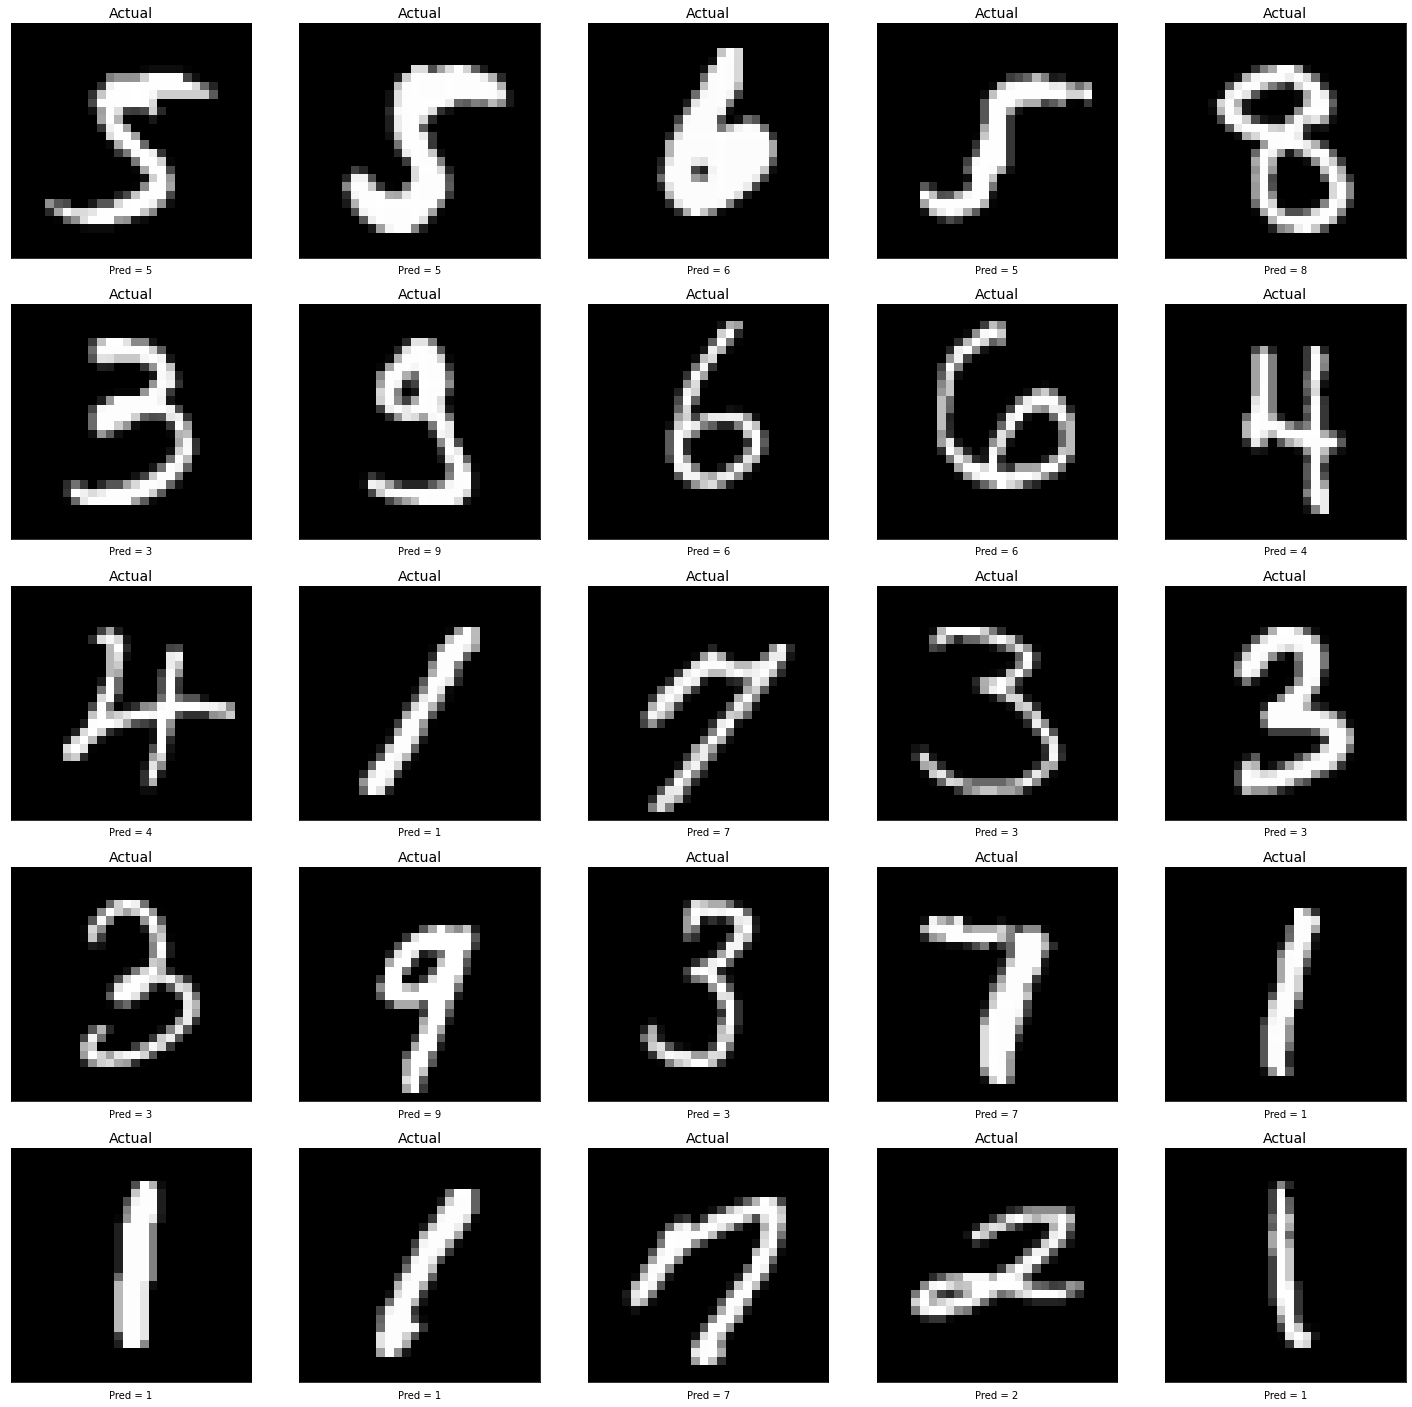

In [34]:
randomDigitsTest()